In [1]:
import pickle

import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from sklearn.metrics import confusion_matrix

## Load dataset

In [2]:
with open('../data/prepared_data.pickle', 'rb') as data:
    data_dic = pickle.load(data)

In [3]:
train = data_dic['full_df']['train']
test  = data_dic['full_df']['test']
valid = data_dic['full_df']['valid']

In [4]:
train_dataset = np.array(train.sentence_vecs.tolist())
test_dataset  = np.array(test.sentence_vecs.tolist())
valid_dataset = np.array(valid.sentence_vecs.tolist())

In [5]:
train_labels = np.array([train.cat1_num.tolist(),train.cat2_num.tolist()]).transpose()
test_labels  = np.array([test.cat1_num.tolist(),test.cat2_num.tolist()]).transpose()
valid_labels = np.array([valid.cat1_num.tolist(),valid.cat2_num.tolist()]).transpose()

In [6]:
vocab_len = data_dic['full_df']['vocab_len']

## Ready for tensorflow!

In [7]:
SEQ_LENGTH = 100
BATCH_SIZE = 100

NUM_LABELS_1 = 6
NUM_LABELS_2 = 64

VOCAB_SIZE = vocab_len
EMBED_SIZE = 128

NUM_NEURONS = 128

FILTER_SIZE_1 = 3
FILTER_SIZE_2 = 4
FILTER_SIZE_3 = 5
NUM_FILTERS = 128

keep_prob = 0.8
l2_reg_lambda=0.002


tf_train_dataset = tf.placeholder(tf.int32, shape=(BATCH_SIZE, SEQ_LENGTH), name="input_x")
tf_train_labels = tf.placeholder(tf.int32, shape=(BATCH_SIZE, 2), name="input_y")
tf_valid_dataset = tf.constant(valid_dataset) 
tf_test_dataset = tf.constant(test_dataset)

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

## Embedding layer

embed_weigths = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0))
    
## Convolutional layers
## Change to True if run again
with tf.variable_scope("vars", reuse = None):
    
    conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE_1, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv1_b")

    conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE_2, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv2_b")

    conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE_3, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv3_b")

## Fully connected layer

    fc_weights = tf.get_variable("fc_w", shape=[3*NUM_FILTERS, NUM_NEURONS],\
                                              initializer=tf.contrib.layers.xavier_initializer())
    
    fc_biases = tf.Variable(tf.constant(1.0, shape=[NUM_NEURONS]), name="fc_b")


    fc1_weights = tf.get_variable("fc1_w", shape=[NUM_NEURONS, NUM_LABELS_1],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS_1]), name = "fc1_b")
    
    fc2_weights = tf.get_variable("fc2_w", shape=[NUM_NEURONS, NUM_LABELS_2],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS_2]), name = "fc2_b")


# Model:
def model(data, keep_prob = keep_prob): 
    
    ## Embedding layer
    ## input shape:[BATCH_SIZE, SEQ_LENGTH]
    ## output shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    
    with tf.device('/cpu:0'), tf.name_scope("word2vec_embedding"):    
        embed_chars = tf.nn.embedding_lookup(embed_weigths, data)
        embed_chars = tf.expand_dims(embed_chars, -1)
    
    ## Conv1+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv1-maxpool-3"):
        conv1 = tf.nn.conv2d(embed_chars, conv1_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, SEQ_LENGTH-FILTER_SIZE_1+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    ## Conv2+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv2-maxpool-4"):
        conv2 = tf.nn.conv2d(embed_chars, conv2_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, SEQ_LENGTH-FILTER_SIZE_2+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Conv3+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv3-maxpool-5"):
        conv3 = tf.nn.conv2d(embed_chars, conv3_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
        pool3 = tf.nn.max_pool(relu3, ksize=[1, SEQ_LENGTH-FILTER_SIZE_3+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Combine pooled features + flatten
    ## input shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    ## output shape: [BATCH_SIZE, 3, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("combine_flatten"):
        pooled_outputs = [pool1, pool2, pool3]
        h_pool = tf.concat(pooled_outputs,3)
        h_pool_flat = tf.reshape(h_pool, [-1, NUM_FILTERS*3])
    
    with tf.name_scope("dropout"):
        hidden = tf.nn.relu(tf.matmul(h_pool_flat, fc_weights) + fc_biases)
        hidden = tf.nn.dropout(hidden, keep_prob) 
    
    ## Fully connected layer
    with tf.name_scope("output"):
        return tf.matmul(hidden, fc1_weights) + fc1_biases,\
               tf.matmul(hidden, fc2_weights) + fc2_biases
  
#Training computation:
logits_1, logits_2 = model(tf_train_dataset)
with tf.name_scope("loss"):
    l2_loss += tf.nn.l2_loss(fc1_weights)
    l2_loss += tf.nn.l2_loss(fc1_biases)
    l2_loss += tf.nn.l2_loss(fc2_weights)
    l2_loss += tf.nn.l2_loss(fc2_biases)
    loss_1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_1, \
                                                                           labels = tf_train_labels[:,0])) 
    loss_2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_2, \
                                                                           labels = tf_train_labels[:,1])) 
    loss = loss_1 + loss_2 + l2_reg_lambda * l2_loss
  
# Optimizer:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#saver = tf.train.Saver()

**Predictions for the training, validation, and test data**

In [ ]:
train_prediction = [tf.nn.softmax(logits_1),\
                    tf.nn.softmax(logits_2)]
valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[0]),\
                    tf.nn.softmax(model(tf_valid_dataset)[1])]
test_prediction =  [tf.nn.softmax(model(tf_test_dataset)[0]),\
                    tf.nn.softmax(model(tf_test_dataset)[1])]

## Train model and report accuracy

In [ ]:
NUM_ITERATIONS = 200001

step = []
pred_cat1 = []
pred_cat2 = []
loss_minibatch = []
accuracy_minibatch_cat1 = []
accuracy_minibatch_cat2 = []
accuracy_valid_cat1 = []
accuracy_valid_cat2 = []

logs_path = '../tensorflow_logs/example_category2_advanced'

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for i in range(NUM_ITERATIONS):
        offset = (i * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
        
        if (i % 4000 == 0): ## info will be printed every 4000th time
            step.append(i)
            print("Minibatch loss at step %d: %f" % (i, l))
            loss_minibatch.append(l)           
            
            m1 = 100*np.sum(np.argmax(predictions[0],1) == batch_labels[:,0]) / predictions[0].shape[0]
            print("Minibatch accuracy cat1: %.1f%%" % m1)
            accuracy_minibatch_cat1.append(m1)
            
            m2 = 100*np.sum(np.argmax(predictions[1],1) == batch_labels[:,1]) / predictions[1].shape[0]
            print("Minibatch accuracy cat2: %.1f%%" % m2)
            accuracy_minibatch_cat2.append(m2)
            
            v1 = 100*np.sum(np.argmax(valid_prediction[0].eval(),1) == valid_labels[:,0]) \
            / valid_prediction[0].eval().shape[0]
            print('Validation accuracy cat1: %.1f%%' % v1)    
            accuracy_valid_cat1.append(v1)
            
            v2 = 100*np.sum(np.argmax(valid_prediction[1].eval(),1) == valid_labels[:,1]) \
            / valid_prediction[1].eval().shape[0]
            print('Validation accuracy cat2: %.1f%%' % v2)    
            accuracy_valid_cat2.append(v2)
    
    t1 = 100*np.sum(np.argmax(test_prediction[0].eval(),1) == test_labels[:,0]) \
            / test_prediction[0].eval().shape[0]
    print("\nTest accuracy cat1: %.1f%%" % t1)
    
    t2 = 100*np.sum(np.argmax(test_prediction[1].eval(),1) == test_labels[:,1]) \
            / test_prediction[1].eval().shape[0]
    print("\nTest accuracy cat2: %.1f%%" % t2)
    
    #save_path = saver.save(session, "../models/cat2_cnn_advanced.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    pred_cat1.append(np.argmax(test_prediction[0].eval(),1))
    pred_cat2.append(np.argmax(test_prediction[1].eval(),1))
    
    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://172.26.179.29:6006/ into your web browser")

pred_cat1 = pred_cat1[0]
pred_cat2 = pred_cat2[0]

Minibatch loss at step 0: 7.346761
Minibatch accuracy cat1: 21.0%
Minibatch accuracy cat2: 3.0%
Validation accuracy cat1: 21.4%
Validation accuracy cat2: 1.9%
Minibatch loss at step 4000: 3.153915
Minibatch accuracy cat1: 70.0%
Minibatch accuracy cat2: 34.0%
Validation accuracy cat1: 72.4%
Validation accuracy cat2: 37.4%
Minibatch loss at step 8000: 3.168174
Minibatch accuracy cat1: 73.0%
Minibatch accuracy cat2: 38.0%
Validation accuracy cat1: 76.5%
Validation accuracy cat2: 45.1%
Minibatch loss at step 12000: 2.472784
Minibatch accuracy cat1: 84.0%
Minibatch accuracy cat2: 50.0%
Validation accuracy cat1: 78.9%
Validation accuracy cat2: 48.6%
Minibatch loss at step 16000: 2.903608
Minibatch accuracy cat1: 78.0%
Minibatch accuracy cat2: 43.0%
Validation accuracy cat1: 79.9%
Validation accuracy cat2: 51.1%
Minibatch loss at step 20000: 2.464565
Minibatch accuracy cat1: 82.0%
Minibatch accuracy cat2: 50.0%
Validation accuracy cat1: 80.5%
Validation accuracy cat2: 52.2%
Minibatch loss at 

## Interpreting confusion matrices & accuracy

In [18]:
cat1_df = train[["cat1_num","cat1"]].drop_duplicates().sort_values(by="cat1_num")
cat1_dict = dict(zip(cat1_df.cat1_num,cat1_df.cat1))

cat1_df

,cat1_num,cat1
1341147,0,baby products
808722,1,beauty
73592,2,grocery gourmet food
985711,3,health personal care
128354,4,pet supplies
539717,5,toys games


In [19]:
cat2_df = train[["cat2_num","cat2"]].drop_duplicates().sort_values(by="cat2_num")
cat2_dict = dict(zip(cat2_df.cat2_num,cat2_df.cat2))

cat2_df

,cat2_num,cat2
559318,0,action toy figures
322965,1,arts crafts
928949,2,baby child care
378604,3,baby toddler toys
51062,4,baby food
719997,5,bath body
863555,6,bathing skin care
41596,7,beverages
237582,8,birds
39560,9,breads bakery


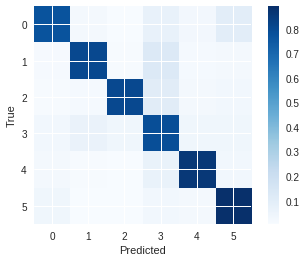

In [20]:
cm = confusion_matrix(test_labels[:,0], pred_cat1)
cm = np.array([np.array([float(x)/sum(cm[i]) for x in cm[i]]) for i in range(cm.shape[0])])

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(6))
plt.yticks(range(6))
plt.xlabel('Predicted')
plt.ylabel('True')

In [21]:
for y in range(cm.shape[0]):
    a = [(i, 100*round(e,1)) for i,e in enumerate(cm[y]) if e>0.1 and i!=y]
    if len(a)>0:
        print ("%.0f%% of products from category %.0f (%s) gets mixed with products from category %.0f (%s)"
               % (a[0][1], y, cat1_dict.get(y), a[0][0], cat1_dict.get(a[0][0])))

10% of products from category 1 ( beauty) gets mixed with products from category 3 ( health  personal care)
10% of products from category 2 ( grocery  gourmet food) gets mixed with products from category 3 ( health  personal care)


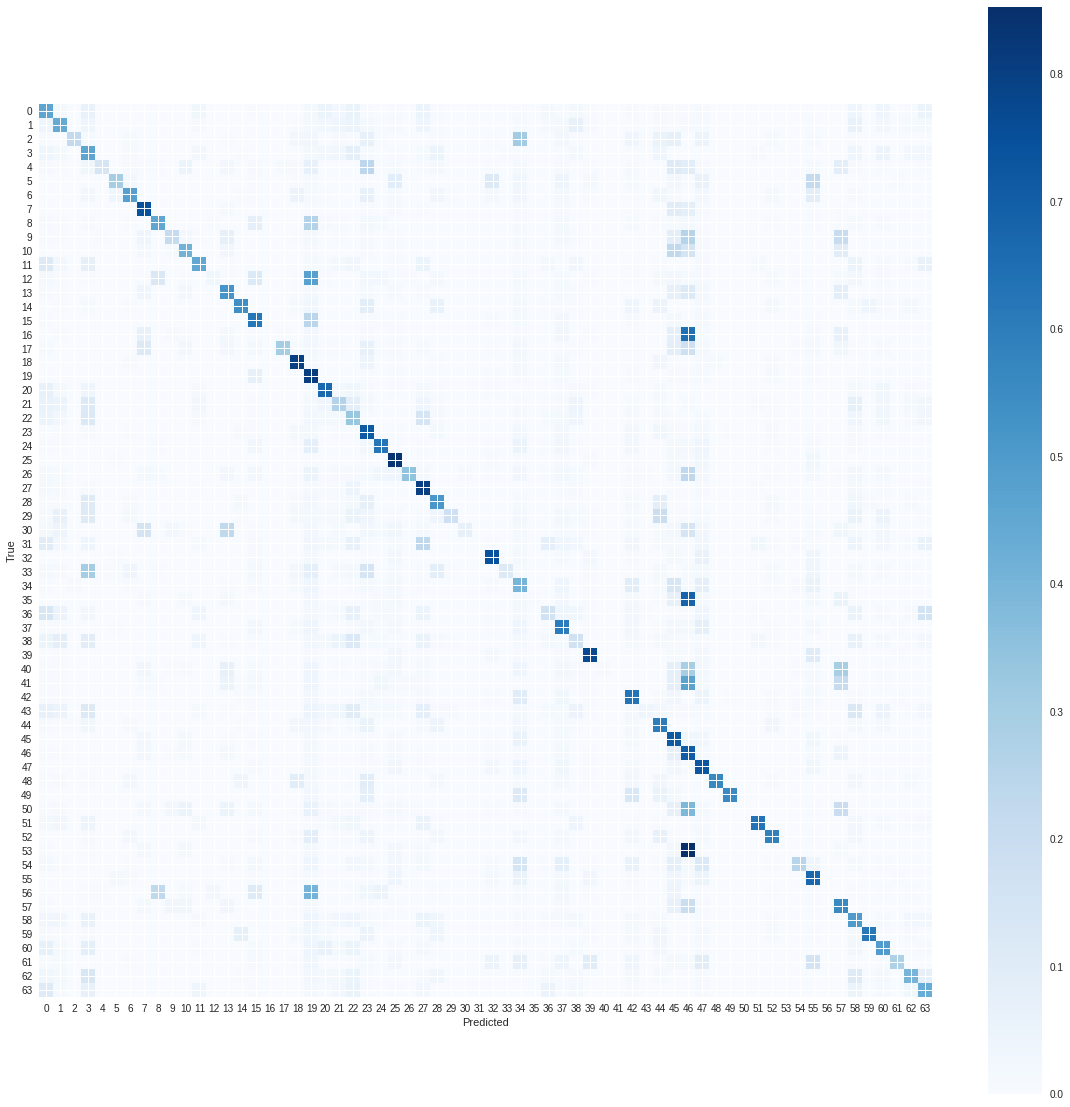

In [22]:
cm = confusion_matrix(test_labels[:,1], pred_cat2)
cm = np.array([np.array([float(x)/sum(cm[i]) for x in cm[i]]) for i in range(cm.shape[0])])

plt.figure(figsize=(20,20))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(range(64))
plt.yticks(range(64))
plt.xlabel('Predicted')
plt.ylabel('True')

In [23]:
for y in range(cm.shape[0]):
    a = [(i, 100*round(e,1)) for i,e in enumerate(cm[y]) if e>0.15 and i!=y]
    if len(a)>0:
        print ("%.0f%% of products from category %.0f (%s) gets mixed with products from category %.0f (%s)"
               % (a[0][1], y, cat2_dict.get(y), a[0][0], cat2_dict.get(a[0][0])))

30% of products from category 2 (baby  child care) gets mixed with products from category 34 (health care)
20% of products from category 4 (baby food) gets mixed with products from category 23 (feeding)
20% of products from category 5 (bath  body) gets mixed with products from category 55 (skin care)
30% of products from category 8 (birds) gets mixed with products from category 19 (dogs)
30% of products from category 9 (breads  bakery) gets mixed with products from category 46 (pantry staples)
20% of products from category 10 (breakfast foods) gets mixed with products from category 45 (nutrition  wellness)
50% of products from category 12 (bunny rabbit central) gets mixed with products from category 19 (dogs)
20% of products from category 15 (cats) gets mixed with products from category 19 (dogs)
60% of products from category 16 (cooking  baking supplies) gets mixed with products from category 46 (pantry staples)
20% of products from category 17 (dairy  eggs) gets mixed with products f

## Model performance evolution

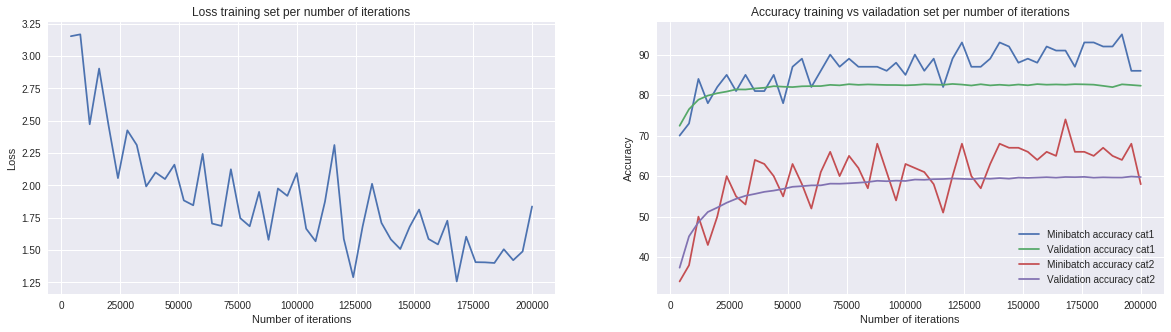

In [24]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')

plt.subplot(1, 2, 2)
plt.plot(step[1:len(step)],accuracy_minibatch_cat1[1:len(step)], label = 'Minibatch accuracy cat1')
plt.plot(step[1:len(step)],accuracy_valid_cat1[1:len(step)], label = 'Validation accuracy cat1')
plt.plot(step[1:len(step)],accuracy_minibatch_cat2[1:len(step)], label = 'Minibatch accuracy cat2')
plt.plot(step[1:len(step)],accuracy_valid_cat2[1:len(step)], label = 'Validation accuracy cat2')
plt.legend(loc = 0)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy training vs vailadation set per number of iterations')

In [25]:
## 82% accuracy cat1; 61% accuracy cat2